In [ ]:
from icevision.all import *
from lunular.data import coco

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /home/rave/.icevision/mmdetection_configs/mmdetection_configs-2.16.0/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17


In [ ]:
model_type = models.torchvision.mask_rcnn
backbone = model_type.backbones.resnet34_fpn()

In [ ]:
ml_data_path = os.path.join(os.path.abspath(os.getcwd()),"../ML/Data")

In [ ]:
import numpy as np
path = Path(ml_data_path)
codes = np.loadtxt(path/'codes-nocoincident.txt', dtype=str)

In [ ]:
def get_chps(path): 
    oil_chps = np.loadtxt(path/'oil_chps.txt', dtype=str)
    density = 0
    num_oilless = density * len(oil_chps)
    oilless_chps = [chp for chp in get_image_files(path/'chp') if chp.stem not in oil_chps]
    mixed_chps = random.sample(oilless_chps,num_oilless) + [path/'chp'/(chp+'.png') for chp in oil_chps]
    return mixed_chps

def get_lbls(fn): return fn.parent.parent/"lbl_no3"/f"{fn.name}"
def splitter_func(path, fn): 
    valid_names = np.loadtxt(path/'valid_names.txt', dtype=str)
    return fn.name.rsplit('_',1)[0] in valid_names # XXX Check to make sure this should be returning True for Valid

drive_files = get_chps(path)

In [ ]:
lbl_chps = [get_lbls(x) for x in get_chps(path)]

In [ ]:
lcl = Path("../out_data")
path.mkdir(exist_ok=True)
modelpath = lcl

In [18]:
img_dir=f"{path}/chp"

### Making a COCO Dataset for Mask-RCNN

#### Annotations from raster labels
##### https://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch this can be incorporated into solaris/lunular later. edited for single channel

In [ ]:
from PIL import Image # (pip install Pillow)
import numpy as np
def create_sub_masks(mask_image):
    width, height = mask_image.size

    # Initialize a dictionary of sub-masks indexed by RGB colors
    sub_masks = {}
    for x in range(width):
        for y in range(height):
            # Get the VV value of the pixel
            pixel = mask_image.getpixel((x,y))

            # If the pixel is not black...
            if pixel != 0:
                # Check to see if we've created a sub-mask...
                pixel_str = str(pixel)
                sub_mask = sub_masks.get(pixel_str)
                if sub_mask is None:
                   # Create a sub-mask (one bit per pixel) and add to the dictionary
                    # Note: we add 1 pixel of padding in each direction
                    # because the contours module doesn't handle cases
                    # where pixels bleed to the edge of the image
                    sub_masks[pixel_str] = Image.new('1', (width+2, height+2))

                # Set the pixel value to 1 (default is 0), accounting for padding
                sub_masks[pixel_str].putpixel((x+1, y+1), 1)

    return sub_masks

import numpy as np                                 # (pip install numpy)
from skimage import measure                        # (pip install scikit-image)
from shapely.geometry import Polygon, MultiPolygon # (pip install Shapely)

def create_sub_mask_annotation(sub_mask, image_id, category_id, annotation_id, is_crowd):
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(sub_mask, 0.5, positive_orientation='low')

    segmentations = []
    polygons = []
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Make a polygon and simplify it
        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology=False)
        polygons.append(poly)
        segmentation = np.array(poly.exterior.coords).ravel().tolist()
        segmentations.append(segmentation)

    # Combine the polygons to calculate the bounding box and area
    multi_poly = MultiPolygon(polygons)
    if len(multi_poly.bounds) == 4:
        x, y, max_x, max_y = multi_poly.bounds
        width = max_x - x
        height = max_y - y
        bbox = (x, y, width, height)
        area = multi_poly.area

        annotation = {
            'segmentation': segmentations,
            'iscrowd': is_crowd,
            'image_id': image_id,
            'category_id': category_id,
            'id': annotation_id,
            'bbox': bbox,
            'area': area
        }
    else:
        annotation = {
            'segmentation': [],
            'iscrowd': is_crowd,
            'image_id': image_id,
            'category_id': category_id,
            'id': annotation_id,
            'bbox': [],
            'area': 0
        }

    return annotation

In [ ]:
import json

def get_annotations_from_raster_lbl(lbl_path):
    mask_image = Image.open(lbl_path)

    mask_images = [mask_image]

    # Define which colors match which categories in the images
    oil_slick_id = [1]
    category_ids = {
        1: {
            '1': oil_slick_id,
        }
    }

    is_crowd = 0

    # These ids will be automatically increased as we go
    annotation_id = 1
    image_id = 1

    # Create the annotations
    annotations = []
    for mask_image in mask_images:
        sub_masks = create_sub_masks(mask_image)
        for color, sub_mask in sub_masks.items():
            category_id = category_ids[image_id][color]
            annotation = create_sub_mask_annotation(np.array(sub_mask), image_id, category_id, annotation_id, is_crowd)
            annotations.append(annotation)
            annotation_id += 1
        image_id += 1

    return json.dumps(annotations)

In [ ]:
chps = get_chps(path)

In [10]:
import datetime
import json
import os
import re
import fnmatch
from PIL import Image
import numpy as np
from pycococreatortools import pycococreatortools
import pycocotools.coco as COCO

info = {
    "description": "CeruleanDataset V1, Binary Slick/Not Slick",
    "url": "none",
    "version": "1.0",
    "year": 2021,
    "contributor": "Skytruth",
    "date_created": "2021/11/12"
}

licenses = [
    {
        "url": "none",
        "id": 1,
        "name": "CeruleanDataset V1, Binary Slick/Not Slick"
    }
]
categories = [{"supercategory":"slick", "id":1,"name":"oil_slick"}]

coco_output = {
    "info": info,
    "licenses": licenses,
    "images": [],
    "annotations": [],
    "categories": categories
}

image_id = 1
segmentation_id = 1

images_d = []

# filter for jpeg images
for i,n in enumerate(chps):
    images_d.append({"file_name": str(n), "height": 512, "width": 512, "id":i})

    # go through each label image to extract annotation
    image = Image.open(str(n))
    image_info = pycococreatortools.create_image_info(
        image_id, os.path.basename(str(n)), image.size)
    coco_output["images"].append(image_info)

    annotation_filename = str(lbl_chps[i])
    arr = np.array(Image.open(annotation_filename))
    if 1 in arr:
        class_id = 1
        category_info = {"id":class_id,"is_crowd":True}
    else:
        class_id = 0
        category_info = {"id":class_id,"is_crowd":False}
    binary_mask = np.asarray(Image.open(annotation_filename)).astype(np.uint8)

    annotation_info = pycococreatortools.create_annotation_info(
        segmentation_id, image_id, category_info, binary_mask,
        image.size, tolerance=0)

    if annotation_info is not None:
        coco_output["annotations"].append(annotation_info)

    segmentation_id = segmentation_id + 1

    image_id = image_id + 1

with open('{}/instances_slick_train.json'.format(path), 'w') as output_json_file:
    json.dump(coco_output, output_json_file)


In [57]:
test_path = [i for i in lbl_chps if "S1A_IW_GRDH_1SDV_20190105T221712_20190105T221737_025348_02CE45_53F2_1" in str(i)]

https://airctic.com/0.8.1/custom_parser/

In [82]:
class_map = ClassMap(["oil_slick"])
class_map # https://airctic.github.io/icedata/dataset_voc_nb/#define-class_map

<ClassMap: {'background': 0, 'oil_slick': 1}>

In [20]:
parser = parsers.COCOMaskParser(f'{path}/instances_slick_train.json', img_dir)

In [21]:
dir(parser)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_path',
 '_record_id2info',
 '_templates',
 'annotations_dict',
 'areas',
 'bboxes',
 'class_map',
 'create_record',
 'filepath',
 'generate_template',
 'idmap',
 'img_dir',
 'img_size',
 'iscrowds',
 'labels_ids',
 'masks',
 'parse',
 'parse_dicted',
 'parse_fields',
 'prepare',
 'record_id',
 'template_record']

  0%|          | 0/434 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/434 [00:00<?, ?it/s]

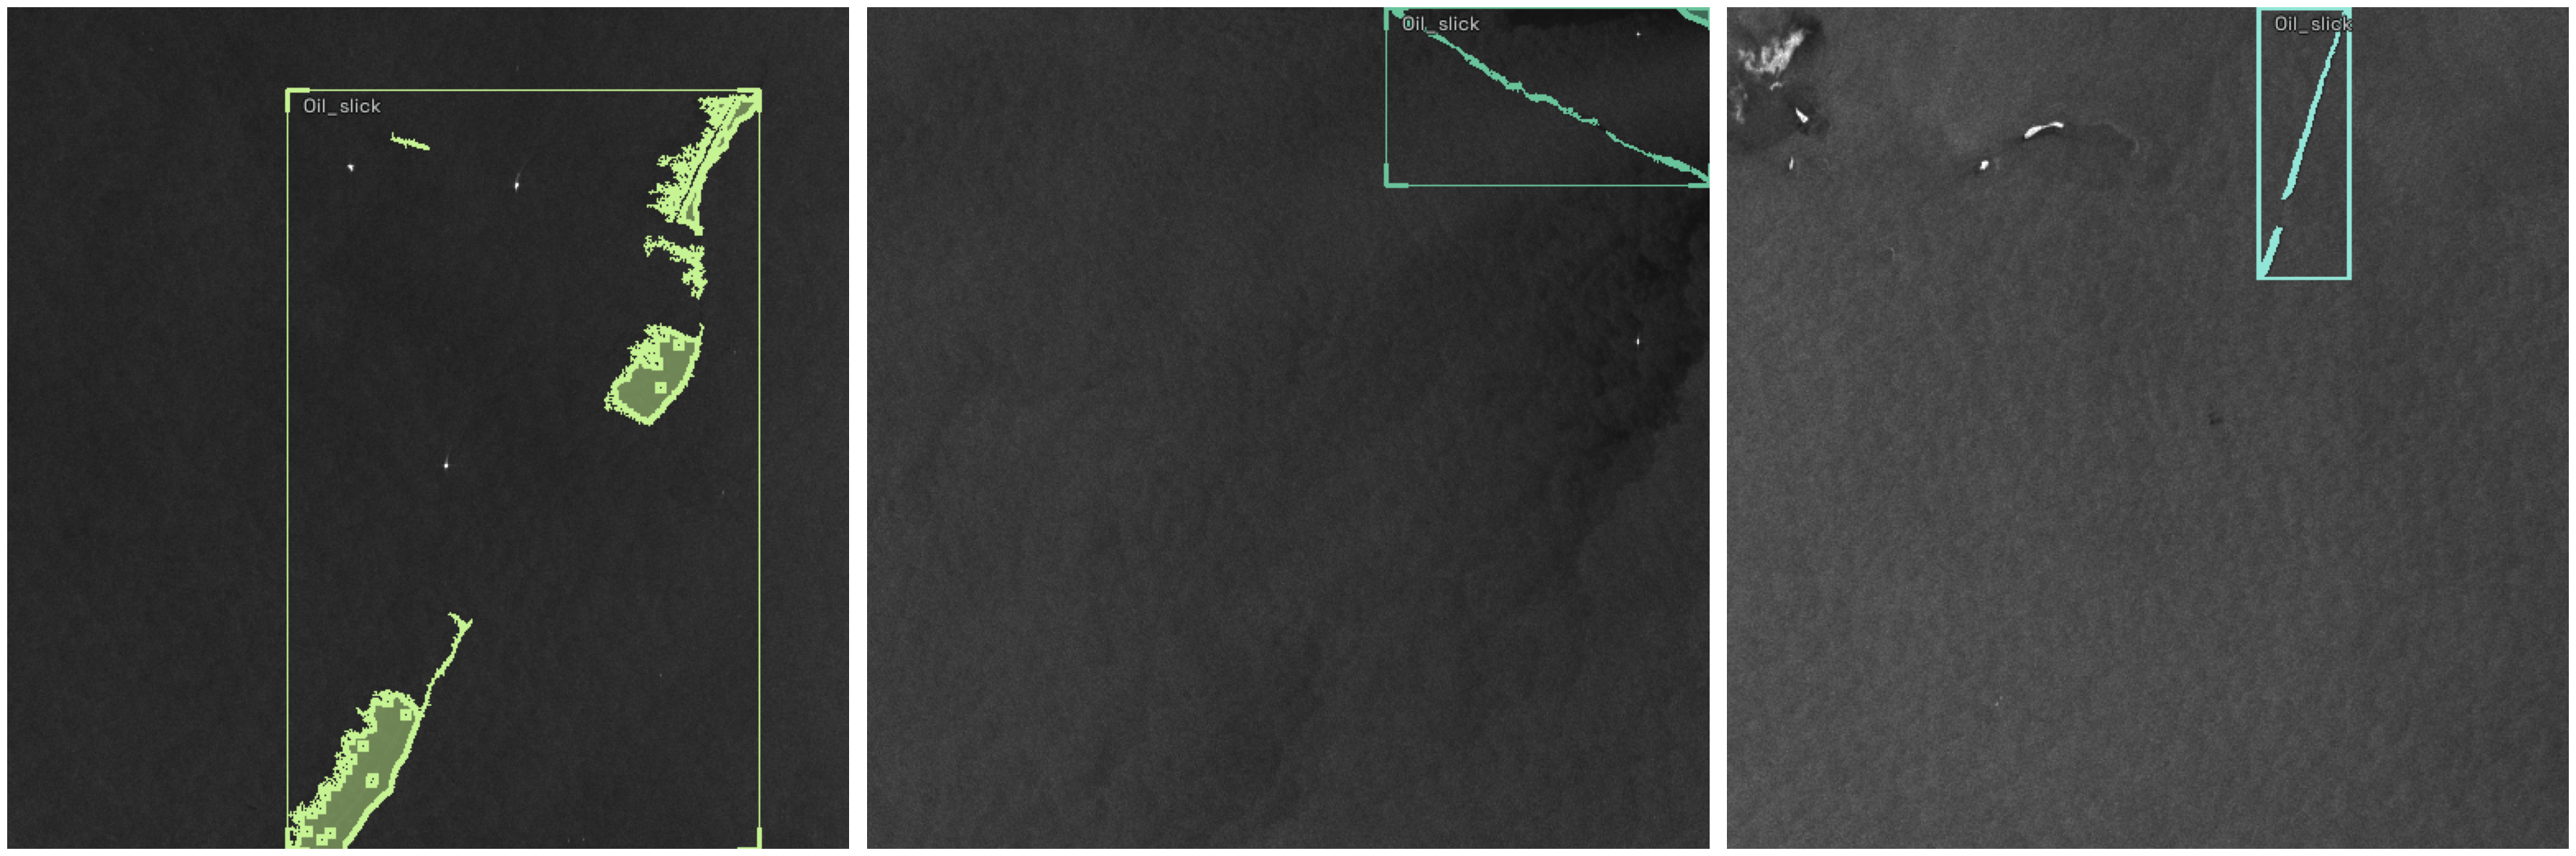

In [22]:
# Parse the annotations to create the train and validation records
train_records, valid_records = parser.parse()
show_records(train_records[:3], ncols=3, class_map=class_map)

Do all transforms happen on the gpu? with icevision? do albumentations transforms happen on gpu?


In [75]:
tfms.transform.Transform??

Init signature: tfms.transform.Transform()
Docstring:     
Helper class that provides a standard way to create an ABC using
inheritance.
Source:        
class Transform(ABC):
    def __call__(self, record: BaseRecord):
        # TODO: this assumes record is already loaded and copied
        # which is generally true
        return self.apply(record)

    @abstractmethod
    def apply(self, record: BaseRecord) -> BaseRecord:
        """Apply the transform
        Returns:
              dict: Modified values, the keys of the dictionary should have the same
              names as the keys received by this function
        """
File:           ~/miniconda3/envs/icevision/lib/python3.8/site-packages/icevision/tfms/transform.py
Type:           ABCMeta
Subclasses:     Adapter


In [74]:
size = 64 # Progressive resizing could happen here
augs = aug_transforms(flip_vert=True, max_warp=0.1, size=size)

NameError: name 'aug_transforms' is not defined

In [11]:
model_type??

Type:        module
String form: <module 'icevision.models.torchvision.mask_rcnn' from '/home/rave/miniconda3/envs/icevision/lib/python3.8/site-packages/icevision/models/torchvision/mask_rcnn/__init__.py'>
File:        ~/miniconda3/envs/icevision/lib/python3.8/site-packages/icevision/models/torchvision/mask_rcnn/__init__.py
Source:     
from icevision.models.torchvision.loss_fn import *

from icevision.models.torchvision.mask_rcnn import backbones
from icevision.models.torchvision.mask_rcnn.dataloaders import *
from icevision.models.torchvision.mask_rcnn.model import *
from icevision.models.torchvision.mask_rcnn.prediction import *
from icevision.models.torchvision.mask_rcnn.show_results import *
from icevision.models.torchvision.mask_rcnn.show_batch import *

# Soft dependencies
from icevision.soft_dependencies import SoftDependencies

if SoftDependencies.fastai:
    import icevision.models.torchvision.mask_rcnn.fastai

if SoftDependencies.pytorch_lightning:
    import icevision.model